# Processing of the Dataset 

In this notebook, I will write the code for importing, processing (feature extraction) and writing the dataset. This is a crucial step before training the neural network. Different features will be extracted to later evaluate their performances.

In [1]:
# Lets import packages
import my_modules_v3_16_04_18 as my
import data_preprocessing as prep
import math
import numpy as np
import h5py
import imp
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import time
import pandas as pd
import wave
import os
import struct
import IPython.display as ipd
import random
import librosa
import soundfile as sf
#from pandas import read_csv,get_dummies

## Now let's loop through the different audio files and:
>#### 1) extract the classes' IDs of the different audio files and save them into a Y vector
>#### 2) extract some features of the wav files and save them into matrix .

# Defining the functions we will need to process the audio files <br>

In [2]:
def add_noise(input_file, db_SNR, index):
    '''Add pink noise to an audio file at a SNR specified 
    by the user
    Dependency: function voss'''
    #Generate normalized pink noise
    noise = prep.normalize(voss(len(input_file)))
    
    # Shift it so that it has mean 0
    noise = noise - np.mean(noise)
    
    #RMS value of the noise
    rms_noise = np.sqrt(np.mean(noise**2))

    #RMS value of the input file
    rms_file = np.sqrt(np.mean(input_file**2)) 

    if rms_file == 0.0:
        print('problem in file %s' %index)
        rms_file = 10**(-8)

    #RMS value required for the noise to provide the specified db_SNR
    rms_noise_required = 10**(-db_SNR/10 + math.log10(rms_file))

    #Coefficient to multiply the noise vector
    coeff = rms_noise_required / rms_noise

    #Scale the noise vector with the calculated coeff
    noise_scaled = noise * coeff
    
    #Add the scaled noise to the input file
    input_file_noised = input_file + noise_scaled

    
    return input_file_noised , noise_scaled
    
    
    

In [3]:
def voss(nrows, ncols=16, seed = 1):
    """Generates pink noise using the Voss-McCartney algorithm.
    
    nrows: number of values to generate
    rcols: number of random sources to add
    
    https://www.dsprelated.com/showarticle/908.php
    returns: NumPy array
    """

    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

In [4]:

voss(3)

array([ 9.18243575,  7.06014398,  7.8537166 ])

In [4]:
def zero_pad(input_file, sampling_rate, desired_length_seconds, noise = False, noise_all = False, db_SNR = 0, index=0):

# A helper function to extend shorter-than-desired-duration audio files into a desired-duration file. 
    # Inputs: 
        # input_file - 1D array of the audio wav file (resampled)
        # sampling_rate - sampling rate of the file
        # desired_length_seconds - desired length of the audio file 
    # Outputs:
        # zero_padded_file, a vector containing the extended input_file
        
    desired_length_samples = sampling_rate * desired_length_seconds 
    needed_length  = int(desired_length_samples - len(input_file)) 
    
    if noise == True:
        if noise_all == True:
            
            input_file, noise_scaled = add_noise(input_file, db_SNR, index) 
            times_add_noise = math.ceil(needed_length/len(noise_scaled))
            noise_to_add = []

            for i in range(times_add_noise):
                noise_to_add.append(noise_scaled)

            noise_to_add = np.squeeze(np.array(noise_to_add).reshape(1,-1))
            zero_padded_file = np.concatenate((input_file,noise_to_add[0:needed_length]),axis=0)
        
        else:
            input_file, _ = add_noise(input_file, db_SNR, index)
            zero_padded_file = np.concatenate((input_file,np.zeros(needed_length)), axis = 0)
        
    else:
        zero_padded_file = np.concatenate((input_file, np.zeros(needed_length)), axis = 0) 
        
    
    return zero_padded_file

In [5]:
def get_files_and_resample(sampling_rate_new, desired_length_seconds, noise = False, noise_all = False, db_SNR = 0):
    
# A function to import the original files, resample them and get also their Class Id
    # Inputs:
        # sampling_rate_new - the new sampling rate we want to apply to all audio files
        # desired_length_seconds - length we want the audio files to have
    # Outputs:
        # x, matrix with dimensions (sampling_rate_new*duration, number_of_examples)
        # y, vector with dimensions (1,number_of_examples)
    
    startpath = os.path.abspath("UrbanSound8K_Test\\audio")
    list_with_file_names1 = os.listdir(startpath) 
    counting_files = []
    counter = 0

    duration_samples = int(desired_length_seconds * sampling_rate_new)
    y = []
    x =[]
    index = 0
#     lista_factors = [0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8]
    
    for file1 in list_with_file_names1:  #Loop over the different folders (fold1, fold2,...)

        if file1 == '.DS_Store':         #Ommit this file
            continue

        completePath1 = os.path.join(startpath,file1) 

        list_with_file_names2 = os.listdir(completePath1)
        
        counting_files.append(counter)
        counter = 0  
        
        print(file1)

        for file2 in list_with_file_names2: #Loop over the different audio files in the different folders (fold1,...)

            if file2 == '.DS_Store':        #Ommit this file
                continue
                
            completePath2 = os.path.join(completePath1,file2)
            
            index += 1
            
            class_id = file2.split("-")[1]     # extract the class id, e.g. 9031-3-1-0.wav --> Class id = 3

#             if random.random() < 0.33:
#                 decision = 0
#             else:
#                 decision = 1

#             if (int(class_id) == 0 and decision == 1):
#                 counter += 1
#                 continue

#             if (int(class_id) == 0):
#                 factor = random.uniform(1.16974196, 1.75461294) * lista_factors[random.uniform(1,16pri)]

#             elif (int(class_id) == 1):
#                 factor = random.uniform(0.91876008, 1.37814012 ) * random.uniform(1,16)
                                
#             elif (int(class_id) == 2):
#                 factor = random.uniform(2.97643903, 4.46465855) * random.uniform(1,16)

#             elif (int(class_id) == 3):
#                 factor = random.uniform(0.89870889, 1.34806333) * random.uniform(1,16)          
                                
#             elif (int(class_id) == 4):
#                 factor = random.uniform(0.98726122, 1.48089184) * random.uniform(1,16)

#             elif (int(class_id) == 5):
#                 factor = random.uniform(0.4, 0.6) * random.uniform(1,16)
                                
#             elif (int(class_id) == 6):
#                 factor = random.uniform(0.68546479, 1.02819718 ) * random.uniform(1,16)

#             elif (int(class_id) == 7):
#                 factor = random.uniform(1.28509061, 1.92763592) * random.uniform(1,16)
                                
#             elif (int(class_id) == 8):
#                 factor = random.uniform(0.73820671, 1.10731007) * random.uniform(1,16)

#             else:
#                 factor = random.uniform(0.73491095, 1.10236643) * random.uniform(1,16)


            input_file, sampling_rate_orig = sf.read(completePath2) #get input file and sampling rate (sf supports 24-bit inputs)
            
            if input_file.ndim == 2:
                input_file = input_file[:,0]    #taking only channel1
                       
            inputfile_resampled = librosa.resample(input_file, sampling_rate_orig, sampling_rate_new) #Resampling
            
            if len(inputfile_resampled) < duration_samples:
                x_files = zero_pad(inputfile_resampled, sampling_rate_new, desired_length_seconds, 
                                  noise = noise, noise_all = noise_all, db_SNR = db_SNR, index=index)
#                 x_files = prep.extend_file(inputfile_resampled, sampling_rate_new, desired_length_seconds)


            elif noise == True:
                x_files, noise_scaled = add_noise(inputfile_resampled[0:duration_samples],db_SNR, index=index)
            
            else:
                x_files = inputfile_resampled[0:duration_samples]
                
                
            y.append(class_id)
            #scaled_files = math.sqrt(factor) * x_files
            x.append(x_files)  #appends to a list of arrays
            
    counting_files.append(counter)
    x2 = np.array(x)
    
    x = np.transpose(x2) #creates an array from the list of arrays, and transposes it to get the desired shape
    y = np.array(y).astype(int) #convert the list to an array

    
    return x, y, counting_files 


# Processing the audio files

In [16]:
#SELECT PARAMETERS
imp.reload(prep)

sampling_rate_new = 22050
duration = 3  #          # duration that I want the audio files to have (in seconds)
mel_bands = 60       # mel frequency bands to extract
window_size = 1024     # for the STFT (in samples)
hop_length = 512   # for the STFT (in samples)

db_SNR = np.array([0, 2, 5, 11])     #SNR pink noise

t = time.time()
i=0
# for i in range(len(db_SNR)-4):

x, y, counting_files = get_files_and_resample(sampling_rate_new, duration, noise = False, noise_all = False, db_SNR = db_SNR[i])

features1 = prep.get_mel_spectrogram(x, sampling_rate_new, mel_bands, window_size, hop_length)
features2 = prep.get_spectrogram(x, window_size, hop_length) #Normalize by nfft... Divide by window_size


elapsed = time.time() - t

#print ('Time elapsed: %s' %elapsed)
# orig_path = r'C:\Users\Santiago\deep-machine-learning\UrbanSound8K_Treated\sr22050,duration3_noise'
# path_features = str(db_SNR[i]) + 'noclass5_' + 'features_mel_SNR.npy'  
# path_labels = str(db_SNR[i]) + 'noclass5_' + 'labels.npy'  
# path_to_save_features = os.path.join(orig_path , path_features)
# path_to_save_labels = os.path.join(orig_path , path_labels)

# np.save(path_to_save_features , features)
# np.save(path_to_save_labels , y)
# print(np.amax(x))
# print(np.mean(x))
# print(x.shape)
# #print(features.shape)
# print(y.shape)

fold0


#### Let's save the values of the spectrogram into a .npy file to open it then from another jupyter notebook

In [19]:
features = np.transpose(features, axes = (1,2,0))
print(features.shape)

(60, 130, 8732)


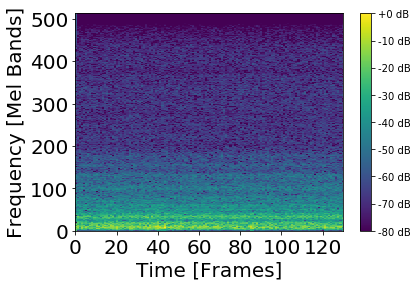

In [25]:
example = 7

#t = np.arange(130)
f = np.arange(60)

f = np.arange(513)
t = np.arange(130)


Sxx = features2[:,:,example]

fig, ax = plt.subplots(1)

p = ax.pcolormesh(Sxx)

fig.colorbar(p, format='%+2.0f dB')
plt.ylabel('Mel [bands]')
plt.xlabel('Time [frames]')
#plt.title('Drilling')

#for item in ([ax.title]):
 #   item.set_fontsize(20)

for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(18)
    
for item in ([] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Mel Bands]')
plt.xlabel('Time [Frames]')
plt.show()

In [32]:
#np.save('ejemplo.npy', features)
np.save(r'C:\Users\Santiago\deep-machine-learning\UrbanSound8K_Treated\sr22050,duration3_leveldiff\orig_features_dB.npy' , features)
#np.save(r'C:\Users\Santiago\deep-machine-learning\UrbanSound8K_Treated\sr22050,duration3_woclasses\noclass0_labels.npy' , y)
#np.save(r'C:\Users\Santiago\deep-machine-learning\UrbanSound8K_Treated\inputs.npy', x)

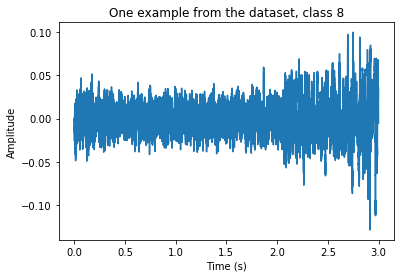

In [13]:
# Lets visualize some of the imported audio files
example = 5

sf.write(r'C:\Users\Santiago\deep-machine-learning\Sounds_for_notebooks\Ejemplin.wav', x[:,example], sampling_rate_new)
ipd.display(ipd.Audio(filename = r'C:\Users\Santiago\deep-machine-learning\Sounds_for_notebooks\Ejemplin.wav'))

time_vector = np.arange(0,x.shape[0],1)/sampling_rate_new
# create the plot
plt.plot(time_vector, x[:,example])
# label the axes
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")
# set the title
plt.title("One example from the dataset, class %s" %y[example])
# display the plot
plt.show()

## Let's plot the spectrogram or the mel-spectrogram in a color plot

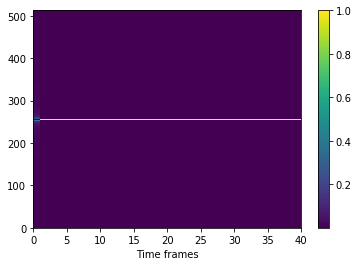

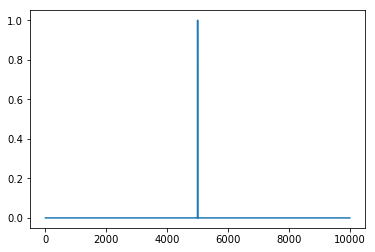

In [4]:
import scipy.fftpack as fft
import librosa
import numpy as np

frequency = 1000
fs = 4 * frequency
time_vector = 1/fs * np.arange(20000)

# create sine wave
sine_wave = np.sin(2 * np.pi * frequency * time_vector)

#transform = np.abs(fft.fft(sine_wave)) / len(sine_wave)
transform = np.abs(np.hanning(len(sine_wave)) * fft.fft(sine_wave)) / np.sum(np.hanning(len(sine_wave)))

window_size = 1024
hop_length = 512
window = np.hanning(window_size)

freq_vector = 1 / window_size * np.arange(window_size)

#out , _ = librosa.core.spectrum._spectrogram(sine_wave, n_fft = window_size, hop_length = hop_length, power = 1)
out  = librosa.core.spectrum.stft(sine_wave, n_fft = window_size, hop_length = hop_length, window = window)
out = 2 * np.abs(out) / np.sum(window)



fig = plt.figure()
axes = fig.add_subplot(111)
#axes.set_yticks(freq_vector)
#fig, axes = plt.subplots(ncols = 1, nrows = 1)
plt.xlabel('Time frames')
im = axes.pcolormesh(out)
fig.colorbar(im)

#axes.yaxis.set_major_locator(plt.MaxNLocator(5))
plt.show()

plt.plot(2 * transform[10000:])

#############################################################
  # PLOTTING OF THE SPECTROGRAMS OF THE DIFFERENT CLASSES #
#############################################################

# t = np.arange(130)
# f = np.arange(60)
# example = 32
# Sxx = features[:,:,example]

# fig, ax = plt.subplots(1)
# ref = np.amax(Sxx)
# #p = ax.pcolormesh(librosa.core.power_to_db(Sxx, ref = ref))
# print(ref)
# p = ax.pcolormesh(Sxx)

# fig.colorbar(p, format='%+2.0f dB')
# plt.ylabel('Mel [bands]')
# plt.xlabel('Time [frames]')
# plt.title('Drilling')

# for item in ([ax.title]):
#     item.set_fontsize(20)

# for item in ([ax.xaxis.label, ax.yaxis.label]):
#     item.set_fontsize(18)
    
# for item in ([] + ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(14)

# for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#              ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(20)

# plt.pcolormesh(t, f, Sxx)
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()

This is a class 3 audio clip


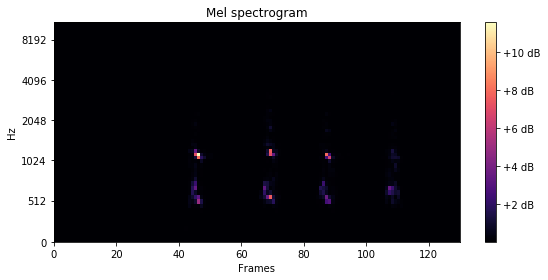

In [39]:
from librosa import display
#features = np.load(r'C:\Users\Santiago\deep-machine-learning\UrbanSound8K_Treated\sr22050,duration3_noise\features_mel_SNR-5dB.npy')
# librosa.power_to_db --> Convert a power spectrogram (amplitude squared) to decibel (dB) units...
# ...basically: 10*log10(S/ref)
example_to_plot = 6
c = sf.write(r'C:\Users\Santiago\deep-machine-learning\Sounds_for_notebooks\Example5.wav',x[:,example_to_plot], sampling_rate_new)
# print(np.sum(features[:,:,example_to_plot]))
ref = np.amax(features[:,:,example_to_plot])
spectrogram_in_db = features[:,:,example_to_plot]
#spectrogram_in_db = librosa.power_to_db((features[:,:,example_to_plot]), ref=ref) 

plt.figure(figsize=(8, 4))
fmin = 0
fmax = sampling_rate_new//2
display.specshow(spectrogram_in_db, sr = sampling_rate_new, hop_length = hop_length , y_axis='mel',fmin=fmin, fmax=fmax,  x_axis='frames')

plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
print ('This is a class %s audio clip' %y[example_to_plot])
ipd.display(ipd.Audio(filename = r'C:\Users\Santiago\deep-machine-learning\Sounds_for_notebooks\Example5.wav'))

In [27]:
# print(y)

[3 3 3 ..., 4 4 4]


In [155]:
y = normalize(voss(500000,16))
y = y - np.mean(y)
print(np.amax(y))
print(np.amin(y))

0.356910295941
-0.358202066592


# ÅF Audio Files

In [88]:
startpath = os.path.abspath(r"C:\Users\Santiago\Desktop\ÅF\for_Asa")
list_with_file_names1 = os.listdir(startpath) 
sampling_rate_orig = 44100
sampling_rate_new = 200 
x =[]
srate = []
desired_length = 16 * sampling_rate_new # 16 seconds at 44.1 kHz sampling rate
for file1 in list_with_file_names1:  #Loop over the different folders (fold1, fold2,...)
 
    completePath1 = os.path.join(startpath,file1) 

    list_with_file_names2 = os.listdir(completePath1) 
        
    for file2 in list_with_file_names2:
            
            completePath2 = os.path.join(completePath1,file2)

            input_file, sampling_rate_orig = sf.read(completePath2) #get input file and sampling rate (sf supports 24-bit inputs)

            if input_file.ndim == 2:
                input_file = input_file[:,0]    #taking only channel1
                
            input_file = librosa.resample(input_file, sampling_rate_orig, sampling_rate_new) #Resampling
                
            if len(input_file) > desired_length:
                input_file = input_file[0:desired_length]
                


            x.append(input_file)  #appends to a list of arrays
            srate.append(sampling_rate_orig)

x = np.transpose(np.array(x)) #creates an array from the list of arrays, and transposes it to get the desired shape
print(x.shape)
srate = np.array(srate)

(3200, 10)


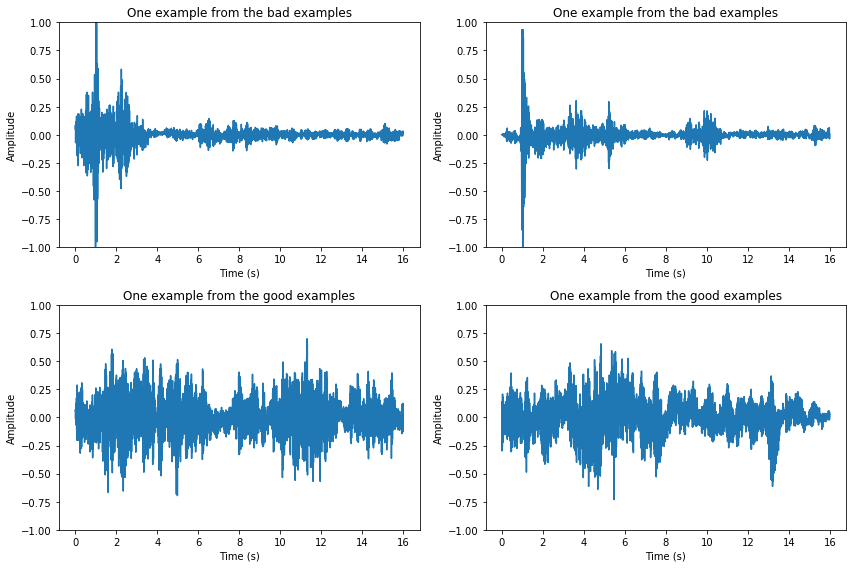

In [89]:
srate = sampling_rate_new
time_vector1 = np.arange(0,x[:,0].shape[0],1)/srate
time_vector2 = np.arange(0,x[:,5].shape[0],1)/srate
time_vector3 = np.arange(0,x[:,7].shape[0],1)/srate
time_vector4 = np.arange(0,x[:,9].shape[0],1)/srate


plt.figure(1, figsize=(12, 8))

plt.subplot(221)
plt.plot(time_vector1, x[:,0])
plt.ylim((-1,1))
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")
plt.title("One example from the bad examples")

plt.subplot(222)
plt.plot(time_vector2, x[:,5])
plt.ylim((-1,1))
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")
plt.title("One example from the bad examples")

plt.subplot(223)
plt.plot(time_vector3, x[:,7])
plt.ylim((-1,1))
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")
plt.title("One example from the good examples")

plt.subplot(224)
plt.plot(time_vector4, x[:,9])
plt.ylim((-1,1))
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")
plt.title("One example from the good examples")

plt.tight_layout()

plt.show()

In [90]:
window_size = 1024
hop_length = 512
mel_bands = 40
#features = get_spectrogram(x,window_size,hop_length)
features = prep.get_mel_spectrogram(x, sampling_rate_new, mel_bands, window_size, hop_length)

In [91]:
print(features.shape)

(40, 7, 10)


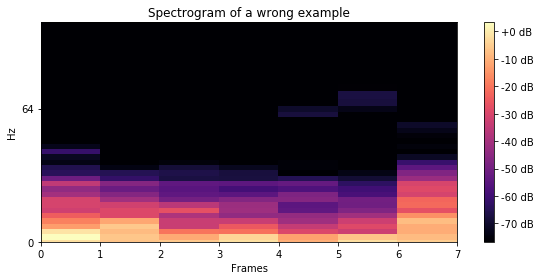

In [97]:
from librosa import display
example_to_plot = 1
ref = np.amax(features[:,:,6])
spectrogram_in_db = librosa.power_to_db(features[:,:,example_to_plot]**2, ref=ref**2) 
#spectrogram_in_db = features[:,:,example_to_plot]
plt.figure(figsize=(8, 4))
fmin = 0
fmax = srate//2
display.specshow(spectrogram_in_db, sr = srate, hop_length = hop_length , y_axis='log',fmin=fmin, fmax=fmax,  x_axis='frames')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of a wrong example')
plt.tight_layout()

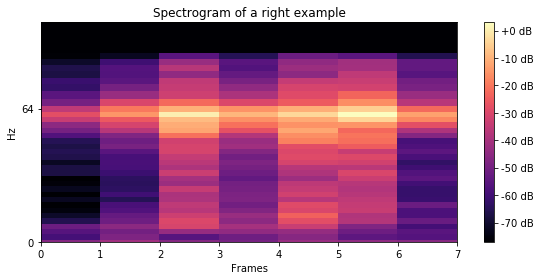

In [95]:
from librosa import display
example_to_plot = 8
ref = np.amax(features[:,:,6])
spectrogram_in_db = librosa.power_to_db(features[:,:,example_to_plot]**2, ref=ref**2) 
plt.figure(figsize=(8, 4))
fmin = 0
fmax = srate/2
display.specshow(spectrogram_in_db, sr = srate, hop_length = hop_length , y_axis='log',fmin=fmin, fmax=fmax,  x_axis='frames')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of a right example')
plt.tight_layout()

In [116]:
input_file, sampling_rate_orig = sf.read(r'C:\Users\Santiago\Desktop\ÅF\254389__jagadamba__male-voice-oh-yeah.wav')
new_sr = 8000
input_file_resampled = librosa.resample(input_file, sampling_rate_orig, new_sr) #Resampling

a = sf.write(r'C:\Users\Santiago\Desktop\ÅF\Example5.wav',input_file, sampling_rate_orig)
b = sf.write(r'C:\Users\Santiago\Desktop\ÅF\Example6.wav',input_file_resampled, 3000)


In [54]:
path = r'C:\Users\Santiago\Desktop\ÅF\Examples_to_play'

list_with_file_names1 = os.listdir(path)      
learned_parameters = retrieve_learned_parameters('saved_model_run-20180418041331')
index = 0 
sampling_rate_new = 22050
duration = 3  #          # duration that I want the audio files to have (in seconds)
mel_bands = 60       # mel frequency bands to extract

window_size = 1024     # for the STFT (in samples)
hop_length = 512      # for the STFT (in samples)

    for file1 in list_with_file_names1:  #Loop over the different folders (fold1, fold2,...)
        index += 1

        _, Z5 = model_for_prediction(X_train[index,:,:,:], Y_train_hot[index,:], learned_parameters)
        predictions = np.argmax(Z5, axis = 1)
        completePath1 = os.path.join(path,file1)


        x, y = get_files_and_resample(sampling_rate_new, duration)
        
        

class_names = ['air corn','car horn','children pl.','dog bark','drilling','engine','gun shot','jackhammer','siren','street music']

#cnf_matrix = confusion_matrix(Y_test, predictions)

#plot_confusion_matrix(cnf_matrix, classes=class_names,
 #                     title='Confusion matrix, without normalization')

INFO:tensorflow:Restoring parameters from b'C:\\Users\\Santiago\\deep-machine-learning\\UrbanSound8K_Treated\\Deprueba\\saved_model_run-20180418041331\\variables\\variables'
Accuracy: 0.7
New accuracy is 0.7


In [47]:
def retrieve_learned_parameters(file_name):
    
    tf.reset_default_graph()  
    root_dir = r'C:\Users\Santiago\deep-machine-learning\UrbanSound8K_Treated\Deprueba'
    directory = os.path.join(root_dir, file_name)
    
    with tf.Session() as sess:  
        tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.TRAINING], directory)
        W1 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)[0].eval()
        b1 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)[1].eval()
        W2 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)[2].eval()
        b2 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)[3].eval()
        W3 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)[4].eval()
        b3 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)[5].eval()
        FC1_w = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)[6].eval()
        FC1_b = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)[7].eval()
        FC2_w = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)[8].eval()
        FC2_b = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)[9].eval()
        #print(tf.global_variables())

        learned_parameters = {'W1':W1, 'W2':W2, 'W3':W3, 'b1':b1, 'b2':b2, 'b3':b3, 
                             'FC1_w':FC1_w, 'FC1_b':FC1_b, 'FC2_w':FC2_w, 'FC2_b':FC2_b}
        
    return learned_parameters

In [51]:
### First let's load some test data ###
from cnn_utils import *
# LOAD DATASET
X = np.load(r'C:\Users\Santiago\deep-machine-learning\UrbanSound8K_Treated\sr22050,duration3\features_mel.npy')
Y = np.load(r'C:\Users\Santiago\deep-machine-learning\UrbanSound8K_Treated\sr22050,duration3\labels.npy')

X= np.transpose(X, axes =(2,0,1))
print(X.shape)
print(Y.shape)
# SPLIT DATASET INTO TRAINING/TEST SETS - I will train on 8 folders and use 1 for testing. 
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 6, random_state = 5, shuffle = False, stratify = None )
# Comment: shuffle is set to false because the files were already randomized when saving them into folders. If I shuffle
# them again, I might mix files from the same slice/ocurrence between test and train sets, making accuracy higher in a 
# wrong way (cheating). When taking minibatches from X_train, that is okey if I shuffle them since that is already going
# to be the unspoiled training set, 873 in first folder. 8732 in total
files_per_folder = [873, 888, 925, 990, 936, 823, 838, 806, 816, 837]

validation_folder = 6  # I won't use one of the folders since that is the one Bello&Piczak used for validation
test_folder = 7
X_train, Y_train, X_val, Y_val, X_test, Y_test  = my.split_dataset(X, Y, validation_folder, test_folder, files_per_folder)


X_train = np.transpose(np.array(X_train, ndmin = 4), axes = (1,2,3,0))
X_val = np.transpose(np.array(X_val, ndmin = 4), axes = (1,2,3,0))
X_test = np.transpose(np.array(X_test, ndmin = 4), axes = (1,2,3,0))
#Common pitfall. An important point to make about the preprocessing is that any preprocessing statistics (e.g. the data mean)
#must only be computed on the training data, and then applied to the validation / test data. E.g. computing the mean and 
#subtracting it from every image across the entire dataset and then splitting the data into train/val/test splits would be
#a mistake. Instead, the mean must be computed only over the training data and then subtracted equally from all 
#splits (train/val/test). http://cs231n.github.io/neural-networks-2/

# NORMALIZE INPUTS TO HAVE MEAN = 0 AND VARIANCE = 1
#X_train = (X_train-np.mean(X_train))/np.std(X_train)
#X_test = (X_test-np.mean(X_train))/np.std(X_train)


# ONE HOT ENCODING OF THE LABELS
Y_train_hot = np.transpose(convert_to_one_hot(Y_train, 10))
Y_val_hot = np.transpose(convert_to_one_hot(Y_val, 10))
Y_test_hot = np.transpose(convert_to_one_hot(Y_test, 10))

(8732, 60, 130)
(8732,)


In [53]:
def model_for_prediction( X_new, Y_new, learned_parameters ):
    
    tf.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
                                          
    m, n_H0, n_W0, n_C0 = X_new.shape
    n_y = Y_new.shape[1]
    
    # Create Placeholders 
    X, Y, _, _ = my.create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Retrieve the learned parameters from the learned_parameters dictionary
    
    W1 = learned_parameters['W1']
    W2 = learned_parameters['W2']
    W3 = learned_parameters['W3']
    b1 = learned_parameters['b1']
    b2 = learned_parameters['b2']
    b3 = learned_parameters['b3']
    FC1_w = learned_parameters['FC1_w']
    FC1_b = learned_parameters['FC1_b']
    FC2_w = learned_parameters['FC2_w']
    FC2_b = learned_parameters['FC2_b']
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    
    # CONV2D: stride of 1 for both time and frequency, padding 'SAME'
    conv1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='VALID', data_format = 'NHWC')
    Z1 = tf.nn.bias_add(conv1, b1)
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='VALID')
    # CONV2D: filters W2, stride 1,
    conv2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='VALID')
    Z2 = tf.nn.bias_add(conv2, b2)
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='VALID')
    # CONV2D: filters W3, stride 1,
    conv3 = tf.nn.conv2d(P2, W3, strides=[1, 1, 1, 1], padding='VALID')
    Z3 = tf.nn.bias_add(conv3, b3)
    A3 = tf.nn.relu(Z3)
    P3 = tf.nn.max_pool(A3, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='VALID')
    # FLATTEN
    P = tf.contrib.layers.flatten(P3)
    
    # FULLY-CONNECTED with 64 neurons in output layer and ReLU activation.   
    Z4 = tf.nn.relu(tf.matmul(P,FC1_w)+FC1_b) 
    
    #FULLY-CONNECTED with 10 neurons in output layer  
    Z5 = tf.nn.softmax(tf.matmul(Z4,FC2_w)+FC2_b)
       
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        tf.global_variables_initializer().run()
         
        Z5 = sess.run(Z5, feed_dict={X:X_new, Y:Y_new})
               
        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z5, 1), tf.argmax(Y, 1)) #Returns the truth value of (x == y) element-wise.
        
        # Calculate accuracy on the new set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) #Casts a tensor to a new type.
        new_accuracy = accuracy.eval({X: X_new, Y: Y_new})
        print("Accuracy:", new_accuracy)

                
    return new_accuracy, Z5

In [55]:
np.log10(0.001)

-3.0

In [33]:
a = [np.array([1,2,3]),np.array([4,5,6])]
b = np.array(a).reshape(1,6)
print(b.shape)
print(b)

(1, 6)
[[1 2 3 4 5 6]]


In [111]:
print(Y.shape)

(8732,)


In [130]:
Y = np.load(r'C:\Users\Santiago\deep-machine-learning\UrbanSound8K_Treated\sr22050,duration3\labels.npy')
files_per_folder = [873, 888, 925, 990, 936, 823, 838, 806, 816, 837]
cuenta = []
suma = 0
for i in range(len(files_per_folder)):
    a = Y[suma:suma+files_per_folder[i]]
    b = list(a).count(8)
    cuenta.append(b)
    suma += files_per_folder[i]

In [131]:
print(cuenta)

[86, 91, 119, 166, 71, 74, 77, 80, 82, 83]


In [118]:
a = np.array([1,2,3])
b = a[0:2]
print(b)

[1 2]


In [17]:
a = np.array([1.3, 2.1, 1.2])
b = np.array(a, dtype =int)
print(b)

[1 2 1]


In [18]:
ola = []
ola1 = ola.append(2)

In [21]:
ola.append(3)
print(ola)

[2, 3]


In [5]:
random.uniform(1,16)

15.155358780628504

In [7]:
print(random.uniform(1,2))

1.4053028484407273
